

# Topic modeling Diffusion of innovation - Technical

In [45]:
# Importing modules
import pandas as pd
import os
# Import the wordcloud library
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

import seaborn as sns; sns.set_theme()
from nltk.stem.porter import PorterStemmer

import numpy as np

import matplotlib.pyplot as plt

import copy

[nltk_data] Downloading package wordnet to /home/d5mit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/d5mit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# functions
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


def get_corpus_id2word(data):
    # convert data to words
    data_words = list(sent_to_words(data))

    # remove stop words
    data_words = remove_stopwords(data_words)

    idocs = []
    for doc in data_words:
        lemmed = [WordNetLemmatizer().lemmatize(w) for w in doc]
#        stemmed = [PorterStemmer().stem(w) for w in doc]        
        idocs.append(lemmed)    
#        idocs.append(stemmed)    

        
        
    
    data_words = idocs
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus, id2word

stop_words = stopwords.words('english')
stop_words.extend(['data',
                   'driven',
                   'show',
                   'get',
                   'knowledge',
                   'yes'
                   'also',
                   'give',
                   'already',
                   'etc',
                   'also',
                   'based',
                   'approach',
                   'analytics',
                   'way',
                   'ensure',
                   'line',
                   'buttom',
                   'yes',
                   'would',
                   'thing',
                   'le',
                   'increase',
                   'use',
                   'using',
                   'make',
                   'made',
                   'definitely',
                   'one',
                   'maybe',
                   'something',
                   'people',
                   'new',
#                    'training',
                   'organisation',
                   'bmw',
                   'v',
                   'create',
                   'nan',
                   'session',
                   'could'
                  ])


In [47]:
def do_topic_model(int_df_text, int_i_stage, int_num_topics, int_i_random_state):
    # get data
    data = int_df_text[int_i_stage].values.tolist()    

    # get corpus and id2words
    corpus, id2word = get_corpus_id2word(data)

    # Build LDA model

    # SOME_FIXED_SEED = 42

    # # before training/inference:
    # np.random.seed(SOME_FIXED_SEED)    

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=int_num_topics,
                                           random_state=int_i_random_state)  

    # save the Keyword in the 10 topics in topics
    topic = lda_model.show_topics(formatted=False)
    ifield = [int_i_stage,topic]
    topics.append(ifield)

    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+int_i_stage+'_'+str(int_num_topics))
    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:

        LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    

        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+int_i_stage+'_'+str(int_num_topics) +'.html')
    return LDAvis_prepared


def visualize_topic_modeling():
    i_stage = 'mt_what_doing_to_improve'
    my_list = ['within', 'sharing', 'within', 'idea', 'session', 'work', 'team', 'exposure', 'skill']    


    # populate dataframe with the weights
    ls_stage = []
    ls_topic = []
    ls_kword = []
    ls_weight = []


    for stages in topics:
        if stages[0] == i_stage:
            for stage in stages[1]: 
                for topic in stage[1]:
                    ls_stage.append(stages[0])
                    ls_topic.append(stage[0])
                    ls_kword.append(topic[0])
                    ls_weight.append(topic[1]) 

    # initialise data of lists.
    data = {'Stage':ls_stage,
            'Topic':ls_topic,
            'Keyword': ls_kword,
            'Value': ls_weight}

    # Create DataFrame
    df = pd.DataFrame(data)

    df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


    ls_words = df['Keyword'].unique().tolist()
    ls_stage_topic = df['Stage_topic'].unique().tolist()

    # heatmap dataframe empty
    df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                         columns=['col1'],
                         index=ls_words)


    # populate heatmap
    for stage_topic in ls_stage_topic:

        ls_iweight = []
        for ikey in ls_words:

            ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
            if len(ivalue) == 1:
                iweight = ivalue[0]
            else:
                iweight = 0 
    #         print(ikey, iweight)
            ls_iweight.append(iweight)

        df_heatmap[stage_topic] = ls_iweight
        df_heatmap

    df_heatmap = df_heatmap.drop(['col1'], axis=1)    

    # remove words that are not adding value    
    df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

    fig, ax = plt.subplots(figsize=(2,5))         # Sample figsize in inches

    cmap = copy.copy(plt.get_cmap("Blues"))
    cmap.set_under('#FFFFFF')

    sns.color_palette("Blues", as_cmap=True)
    sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);           

In [48]:
df_text = pd.read_excel(open('data/output.xlsx','rb'))# Print head
df_text.head()

,Unnamed: 0,resp_id,colle_id,start_date,end_date,ip_address,email,first_name,last_name,custom_data,...,sy_trust_to_adoption,sy_lack_trust_low_adoption,ai_transparency_to_trust,ai_accountability_to_trust,ai_fairness_to_trust,ai_trust_to_adoption,ai_lack_trust_low_adoption,ai_must_be_trans_expl,ai_ethical_considerations,ai_fat_to_trust
0,1,12897837208,404063954,2021-08-17 11:13:06.000000,2021-08-17 12:04:29.000001,160.48.234.77,NaN,NaN,NaN,NaN,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,4.0
1,2,12897754778,404063954,2021-08-17 10:31:55.000000,2021-08-17 11:16:19.999999,160.48.234.77,NaN,NaN,NaN,NaN,...,4.0,3.0,3.0,4.0,3.0,4.0,2.0,4.0,NaN,4.0
2,3,12897751825,404063954,2021-08-17 10:04:39.000001,2021-08-17 11:13:03.000000,160.48.234.77,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,12897749324,404063954,2021-08-17 10:03:00.999999,2021-08-17 11:12:40.000000,160.48.234.78,NaN,NaN,NaN,NaN,...,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,NaN,5.0
4,5,12897725977,404063954,2021-08-17 10:05:33.000000,2021-08-17 11:00:03.000000,160.48.234.78,NaN,NaN,NaN,NaN,...,5.0,5.0,3.0,5.0,5.0,5.0,5.0,4.0,NaN,4.0


In [49]:
list_columns = df_text.columns.to_list()
list_columns

['Unnamed: 0',
 'resp_id',
 'colle_id',
 'start_date',
 'end_date',
 'ip_address',
 'email',
 'first_name',
 'last_name',
 'custom_data',
 'consent',
 'd_tools',
 'd_capabilities',
 'd_culture',
 'd_acts_on_data',
 'd_fin_benefits',
 'd_non_fin_benefits',
 'd_agree_on_def',
 'd_def_comments',
 'm_maturity_rating',
 'm_can_improve',
 'm_how_to_improve',
 'mo_size',
 'mo_man_sup',
 'mo_org_ready',
 'mo_champion',
 'mo_scope',
 'mo_strategy_plan',
 'mo_infrastructure',
 'mo_satisfaction_exist_sys',
 'mo_fin_cost',
 'mo_perc_tech_comp',
 'mo_fin_resources',
 'mo_fin_commitment',
 'mo_fairness',
 'mo_others',
 'me_comp_press',
 'me_industry_press',
 'me_government_press',
 'me_preformance_gap',
 'me_mark_unce',
 'me_regu_envi',
 'me_regu_supp',
 'me_vendor_supp',
 'me_risk_appetite',
 'me_availibility_new_inno',
 'me_accountable',
 'me_others',
 'mt_tech_compatibility',
 'mt_tech_compexity',
 'mt_perc_barriers',
 'mt_perc_benefits',
 'mt_perc_simplicity',
 'mt_tech_competence',
 'mt_tech_in

Only keep certain columns in the dataframe:

In [50]:
columns_to_use = [
    'mt_what_doing_to_improve',
    'mt_what_can_improve',
    'how_to_confim_success',
    'adv_of_data_driven',
    'how_to_compatibility_of_tech',
    'how_to_reduce_compexity',
    'how_to_incr_trialability',
    'how_to_advant_visible',
    'what_would_prevent_usage' ]

df_text = df_text[columns_to_use]
df_text


,mt_what_doing_to_improve,mt_what_can_improve,how_to_confim_success,adv_of_data_driven,how_to_compatibility_of_tech,how_to_reduce_compexity,how_to_incr_trialability,how_to_advant_visible,what_would_prevent_usage
0,Big focus on cloud technologies and architecture.,NaN,Increase in usage of data / analytics tool. Ex...,Predictions are based on facts and figures.,Proper investigation of available technologies...,"Awareness, ""heads-up"", training and upskilling...",Maybe to pilot the system or give access to th...,Using different communication platforms...add ...,Knowledge of the system and the benefits of us...
1,SAP Analytics Cloud BW4HANA,NaN,the increase of projects being approved.,better decisions can be made,by keeping up too date and making sure the peo...,provide training,making sure the people understand the system,.,not having access to it and not understanding ...
2,NaN,NaN,Reflecting on suggestions/solutions brought ab...,Pro-activeness and solving issues before they ...,"Not sure, might depend on the technologies.",Explaining the tools and techniques simply - s...,"Yes, sandbox environments and limited free-tie...",By showing real-life examples of simple change...,Authorisation/Access and cost.
3,Various techoligies are available to accelarat...,NaN,Investigate what drives decision making (at a ...,"Competitive advantage, Ensuring that the organ...",A clear technology roadmap .is needed,"Complexity is inevitable, but a common thread ...",Access to build ad-hoc solutions.,Technology days,When I do not trust the data that is presented...
4,investing in data analytics,keep on looking,better decisions made at a strategic level. pr...,e.g. information that can be used as an advant...,proper architecture planning and long term vie...,"make it available to the users, training, ince...",buy in from the business users with real quest...,specific trails in the company to compare befo...,complexity
...,...,...,...,...,...,...,...,...,...
133,"Data lakes, business intelligence and cloud te...",NaN,Ask people difficult questions to see what the...,Better insights and better more informed decis...,Make sure that there is a central point dictat...,Provide training to understand data-driven tools.,Make it very simple to run pilot studies. Enab...,Asking questions that cannot be answered witho...,Difficulty in understanding Steep learning cu...
134,"Constant software updates, cloud training, har...",NaN,"Compare the speed, quality, efficiency, scalab...",Data is the most valuable resource on the plan...,Ensure the infrastructure being used is flexib...,Training with show and tell.,"Hmm tough one, I imagine access to sandboxes t...",Client feedback across the board should be sha...,If the system is not aligned for the work at h...
135,moving to the cloud that has more mature analy...,look at new technologies and not to get stuck ...,financial gains and being more relative in the...,knowledge over competitors. knowing what is go...,"invest more in new technologies, always try so...",having more workshops and training to make the...,having a save place to test and do POC's,having someone of a department trying new thin...,"I also try something that I don't know, so not..."
136,Highly available processes,A more robust governance framework,results in the culture,measurable decision making,ensuring a standardization in data models acr...,make stakeholders understand better,have a team for this,proper feedback system,unethical use of data


In [51]:
list_columns = df_text.columns.to_list()
list_columns

['mt_what_doing_to_improve',
 'mt_what_can_improve',
 'how_to_confim_success',
 'adv_of_data_driven',
 'how_to_compatibility_of_tech',
 'how_to_reduce_compexity',
 'how_to_incr_trialability',
 'how_to_advant_visible',
 'what_would_prevent_usage']

## Data cleaning
Remove punctuation/lower casing

In [52]:
# synomymns 
df_text = df_text.replace({'company': 'organisation'}, regex=True)
df_text = df_text.replace({'organization': 'organisation'}, regex=True)
df_text = df_text.replace({'great': 'good'}, regex=True)
df_text = df_text.replace({'mng': 'management'}, regex=True)



In [53]:
# take our special characters
for i_column in list_columns:
    df_text[i_column]      = df_text[i_column].str.replace('[^a-zA-Z0-9]', ' ').values.astype(str)    

/tmp/ipykernel_9477/1835935124.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_text[i_column]      = df_text[i_column].str.replace('[^a-zA-Z0-9]', ' ').values.astype(str)


mt_what_doing_to_improve :


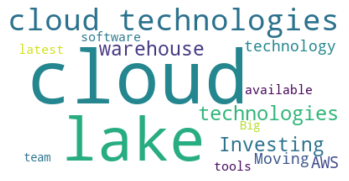

mt_what_can_improve :


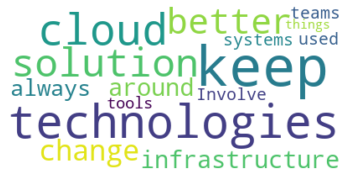

how_to_confim_success :


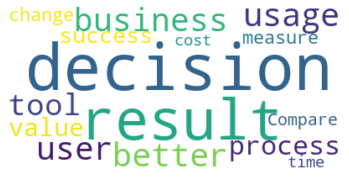

adv_of_data_driven :


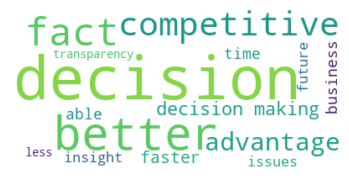

how_to_compatibility_of_tech :


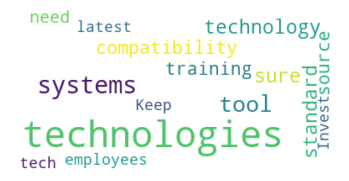

how_to_reduce_compexity :


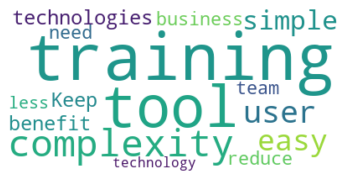

how_to_incr_trialability :


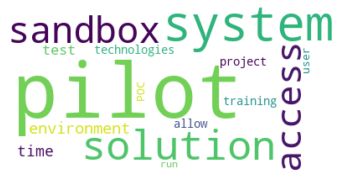

how_to_advant_visible :


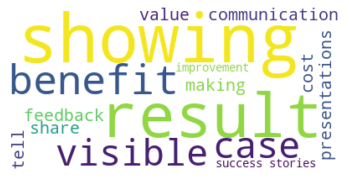

what_would_prevent_usage :


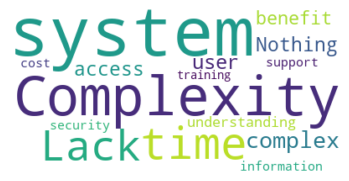

In [54]:
# print wordclouds   
for i_column in list_columns:    
    print(i_column, ':')
    # Join the different processed titles together.
    long_string = ','.join(list(df_text[i_column].values))
    # Create a WordCloud object
    wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=15, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()    
    

## Prepare data for LDA Analysis


In [55]:
topics = []

# print(topics[0])
# print(topics[0][1])
# print(topics[0][1][0][0], topics[0][1][0][1])

In [56]:
i_random_state = 1
i_stage = 'mt_what_doing_to_improve'
num_topics = 3
LDAvis_prepared = do_topic_model(df_text, i_stage, num_topics, i_random_state)

/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  f

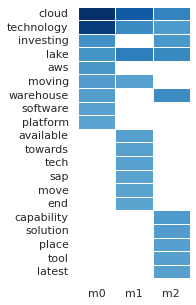

In [57]:
visualize_topic_modeling()

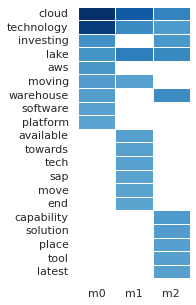

In [43]:
i_stage = 'mt_what_doing_to_improve'
my_list = ['within', 'sharing', 'within', 'idea', 'session', 'work', 'team', 'exposure', 'skill']    


# populate dataframe with the weights
ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == i_stage:
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
                
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    

# remove words that are not adding value    
df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

fig, ax = plt.subplots(figsize=(2,5))         # Sample figsize in inches

cmap = copy.copy(plt.get_cmap("Blues"))
cmap.set_under('#FFFFFF')

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);        

In [66]:
# paramaters
i_stage = 'persuasion'
num_topics = 3

# get data
data = df_text[i_stage].values.tolist()    

# get corpus and id2words
corpus, id2word = get_corpus_id2word(data)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=6)  #1 2

# save the Keyword in the 10 topics in topics
topic = lda_model.show_topics(formatted=False)
ifield = [i_stage,topic]
topics.append(ifield)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+i_stage+'_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    
    
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+i_stage+'_'+str(num_topics) +'.html')
LDAvis_prepared

/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  f

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.066395 -0.027964       1        1  36.910972
1     -0.062278 -0.033902       2        1  33.679028
0     -0.004117  0.061866       3        1  29.410001, topic_info=            Term       Freq      Total Category  logprob  loglift
30         value  10.000000  10.000000  Default  30.0000  30.0000
89         proof   3.000000   3.000000  Default  29.0000  29.0000
112         team   5.000000   5.000000  Default  28.0000  28.0000
81       success   4.000000   4.000000  Default  27.0000  27.0000
46     advantage   5.000000   5.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
255         user   1.507240   3.740412   Topic3  -5.1228   0.3149
5        benefit   2.420143  12.607178   Topic3  -4.6493  -0.4266
260       reward   1.405742   3.751856   Topic3  -5.1925   0.2422
30         value   1.530261  10.723095   Topic3  -5.1077  -0.7231
172  demonstrate   1.248631   4.390640   Topic3  -5.3110  -0.0336

[189 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
189       3  0.542688   accurate
277       1  0.526274     action
347       2  0.529971   actually
46        1  0.535294  advantage
46        3  0.535294  advantage
...     ...       ...        ...
14        1  0.590716       work
14        2  0.196905       work
33        1  0.226989   workshop
33        2  0.680967   workshop
33        3  0.226989   workshop

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

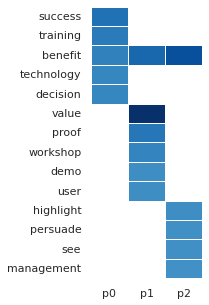

In [67]:
i_stage = 'persuasion'
my_list = ['process', 'understand', 'department', 'awareness', 'conversation', 'take', 'incentive', 'showing', 'result',
           'session', 'work', 'team', 'exposure', 'skill', 'around', 'presuade', 'demonstrate', 'advantage', 'example']    


# populate dataframe with the weights
ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == i_stage:
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
                
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    

# remove words that are not adding value    
df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

fig, ax = plt.subplots(figsize=(2,5))         # Sample figsize in inches

cmap = copy.copy(plt.get_cmap("Blues"))
cmap.set_under('#FFFFFF')

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);        

In [68]:
topics = []
# paramaters
i_stage = 'decision'
num_topics = 4

# get data
data = df_text[i_stage].values.tolist()    

# get corpus and id2words
corpus, id2word = get_corpus_id2word(data)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=4)  #1                                        

# save the Keyword in the 10 topics in topics
topic = lda_model.show_topics(formatted=False)
ifield = [i_stage,topic]
topics.append(ifield)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+i_stage+'_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    
    
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+i_stage+'_'+str(num_topics) +'.html')
LDAvis_prepared

/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.089638  0.056147       1        1  28.860742
1     -0.016181 -0.093479       2        1  26.922792
2      0.017836 -0.003360       3        1  23.573394
0      0.087983  0.040692       4        1  20.643072, topic_info=           Term      Freq     Total Category  logprob  loglift
306         day  2.000000  2.000000  Default  30.0000  30.0000
67         time  6.000000  6.000000  Default  29.0000  29.0000
112    business  7.000000  7.000000  Default  28.0000  28.0000
235    customer  2.000000  2.000000  Default  27.0000  27.0000
105  management  3.000000  3.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
190         add  0.716747  2.490708   Topic4  -5.2832   0.3322
41       making  0.715316  4.353855   Topic4  -5.2852  -0.2283
69         even  0.714682  1.821297   Topic4  -5.2861   0.6423
32     platform  0.714431  1.799254   Topic4  -5.2864   0.6541
127      really  0.714380  1.863265   Topic4  -5.2865   0.6191

[243 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
137       3  0.816174   accessible
372       2  0.801392  accountable
190       1  0.401492          add
190       2  0.401492          add
190       4  0.401492          add
...     ...       ...          ...
256       3  0.317301         work
371       2  0.801349        worth
382       3  0.816192        wrong
166       2  0.406560         year
166       4  0.406560         year

[269 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

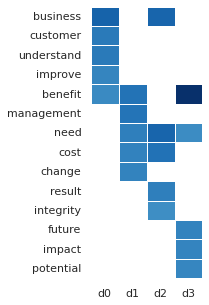

In [69]:
i_stage = 'decision'
my_list = ['decision', 'advantage', 'see', 'want', 'store', 'whether', 'time', 'value', 'day', 'factor', 'current', 'making', 'better']    


# populate dataframe with the weights
ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == i_stage:
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
                
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    

# remove words that are not adding value    
df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

fig, ax = plt.subplots(figsize=(2,5))         # Sample figsize in inches

cmap = copy.copy(plt.get_cmap("Blues"))
cmap.set_under('#FFFFFF')

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);        

In [70]:
# paramaters
topics = []
i_stage = 'implementation'
num_topics = 2

# get data
data = df_text[i_stage].values.tolist()    

# get corpus and id2words
corpus, id2word = get_corpus_id2word(data)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=1)  #1                                        

# save the Keyword in the 10 topics in topics
topic = lda_model.show_topics(formatted=False)
ifield = [i_stage,topic]
topics.append(ifield)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+i_stage+'_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    
    
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+i_stage+'_'+str(num_topics) +'.html')
LDAvis_prepared

/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.016921  0.0       1        1  59.366183
1     -0.016921  0.0       2        1  40.633817, topic_info=        Term      Freq     Total Category  logprob  loglift
15     skill  2.000000  2.000000  Default  30.0000  30.0000
114    forum  1.000000  1.000000  Default  29.0000  29.0000
237     good  1.000000  1.000000  Default  28.0000  28.0000
12      part  2.000000  2.000000  Default  27.0000  27.0000
97    hiring  1.000000  1.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
49      work  0.783306  1.648664   Topic2  -5.1959   0.1564
151     need  0.939846  2.844496   Topic2  -5.0137  -0.2069
30   benefit  0.843308  2.251410   Topic2  -5.1221  -0.0814
148     team  0.808457  2.260634   Topic2  -5.1643  -0.1277
3      focus  0.714652  2.285436   Topic2  -5.2876  -0.2619

[133 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
18        2  0.939422   achieving
149       1  0.593299       adapt
149       2  0.593299       adapt
7         2  0.951312  additional
262       1  0.862735    advanced
...     ...       ...         ...
254       1  0.860085       video
49        1  0.606552        work
49        2  0.606552        work
196       2  0.937042     working
155       1  0.861978       world

[130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

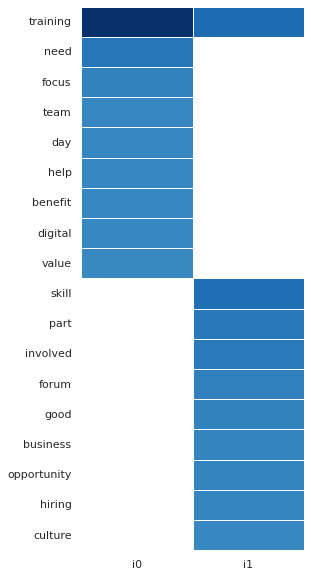

In [71]:
i_stage = 'implementation'
# my_list = ['implement', 'day', 'digital', 'good', 'hiring', 'skill', 'opportunity', 'focus', 'training']    
my_list = ['implement'] 


# populate dataframe with the weights
ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == i_stage:
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
                
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    

# remove words that are not adding value    
df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

fig, ax = plt.subplots(figsize=(4,10))         # Sample figsize in inches

cmap = copy.copy(plt.get_cmap("Blues"))
cmap.set_under('#FFFFFF')

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);     

In [72]:
# paramaters
i_stage = 'confirmation'
num_topics = 3
topics = []

# get data
data = df_text[i_stage].values.tolist()    

# get corpus and id2words
corpus, id2word = get_corpus_id2word(data)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=1)  #1                                         

# save the Keyword in the 10 topics in topics
topic = lda_model.show_topics(formatted=False)
ifield = [i_stage,topic]
topics.append(ifield)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+i_stage+'_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    
    
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+i_stage+'_'+str(num_topics) +'.html')
LDAvis_prepared

/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.037932  0.058887       1        1  46.222509
0     -0.036773 -0.059499       2        1  32.335282
2      0.074704  0.000612       3        1  21.442209, topic_info=               Term      Freq      Total Category  logprob  loglift
174           value  5.000000   5.000000  Default  30.0000  30.0000
81             user  6.000000   6.000000  Default  29.0000  29.0000
24          success  5.000000   5.000000  Default  28.0000  28.0000
26   transformation  4.000000   4.000000  Default  27.0000  27.0000
188           first  2.000000   2.000000  Default  26.0000  26.0000
..              ...       ...        ...      ...      ...      ...
16             like  0.793506   2.571202   Topic3  -5.4165   0.3641
20           result  0.943386  12.839282   Topic3  -5.2435  -1.0710
19             need  0.829202   4.545851   Topic3  -5.3725  -0.1617
8          decision  0.904435  19.792587   Topic3  -5.2857  -1.5459
206         product  0.783916   3.853899   Topic3  -5.4287  -0.0527

[198 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
134       1  0.981593    access
33        1  0.648283  accurate
33        2  0.216094  accurate
33        3  0.216094  accurate
230       1  0.984182  actioned
...     ...       ...       ...
174       2  0.872194     value
210       1  0.494322      view
55        1  0.984452   visible
185       2  0.524304      well
387       2  0.787742     whole

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

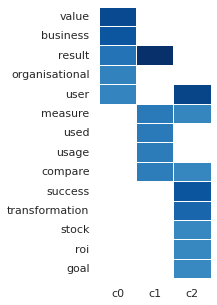

In [73]:
i_stage = 'confirmation'
my_list = ['decision', 'process', 'day', 'tool', 'quality', 'making', 'time', 'information', 'end', 'track', 'first', 'see', 'change',
           'better', 'cost', 'outcome']    


# populate dataframe with the weights
ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == i_stage:
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
                
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    

# remove words that are not adding value    
df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

fig, ax = plt.subplots(figsize=(2,5))         # Sample figsize in inches

cmap = copy.copy(plt.get_cmap("Blues"))
cmap.set_under('#FFFFFF')

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);     

In [74]:
# paramaters
topics = []
i_stage = 'momentum'
num_topics = 3

# get data
data = df_text[i_stage].values.tolist()    

# get corpus and id2words
corpus, id2word = get_corpus_id2word(data)

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=5)  #2  4                                      

# save the Keyword in the 10 topics in topics
topic = lda_model.show_topics(formatted=False)
ifield = [i_stage,topic]
topics.append(ifield)

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+i_stage+'_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)    
    
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+i_stage+'_'+str(num_topics) +'.html')
LDAvis_prepared

/home/d5mit/anaconda3/envs/data-driven-org/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.056780 -0.037927       1        1  35.807742
2     -0.066431 -0.023493       2        1  35.484062
1      0.009651  0.061421       3        1  28.708196, topic_info=           Term       Freq      Total Category  logprob  loglift
34         work   7.000000   7.000000  Default  30.0000  30.0000
80      benefit  12.000000  12.000000  Default  29.0000  29.0000
183    training   3.000000   3.000000  Default  28.0000  28.0000
60      culture   5.000000   5.000000  Default  27.0000  27.0000
68          top   5.000000   5.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
17         keep   1.766478  10.376716   Topic3  -5.0236  -0.5226
72   management   1.622905   7.752861   Topic3  -5.1083  -0.3159
139        goal   1.631998   8.389947   Topic3  -5.1028  -0.3892
44      barrier   1.522583   6.590218   Topic3  -5.1722  -0.2172
108        team   1.449902   5.761681   Topic3  -5.2211  -0.1317

[211 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
200       1  0.605179         able
200       2  0.302590         able
349       1  0.745985       access
172       1  0.986001  achievement
191       3  0.786199      acquire
...     ...       ...          ...
34        1  0.131376         work
34        2  0.656879         work
34        3  0.262752         work
291       1  0.745828        world
184       3  0.786255        wrong

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

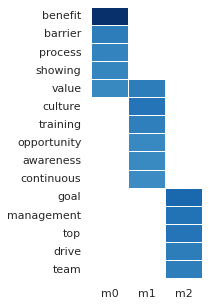

In [75]:
i_stage = 'momentum'
my_list = ['back', 'pushing', 'work', 'identify', 'change', 'incentive', 'keep', 'time', 'need']    


# populate dataframe with the weights
ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == i_stage:
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
                
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    

# remove words that are not adding value    
df_heatmap  = df_heatmap[~df_heatmap.index.isin(my_list)] 

fig, ax = plt.subplots(figsize=(2,5))         # Sample figsize in inches

cmap = copy.copy(plt.get_cmap("Blues"))
cmap.set_under('#FFFFFF')

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap=cmap, cbar=False, vmin=1e-5, center=1e-100);    

In [76]:
topics[0][1]

[(0,
  [('benefit', 0.02437083),
   ('change', 0.013820065),
   ('back', 0.0102499705),
   ('barrier', 0.009965627),
   ('keep', 0.009691165),
   ('identify', 0.008999101),
   ('process', 0.008906201),
   ('showing', 0.00844237),
   ('value', 0.007768368),
   ('incentive', 0.007316306)]),
 (1,
  [('change', 0.02009361),
   ('culture', 0.011557066),
   ('value', 0.010041618),
   ('training', 0.009681191),
   ('incentive', 0.009199268),
   ('time', 0.008732674),
   ('opportunity', 0.007925109),
   ('need', 0.007829571),
   ('awareness', 0.007472009),
   ('continuous', 0.0070809466)]),
 (2,
  [('work', 0.016236557),
   ('keep', 0.016172396),
   ('goal', 0.0137474),
   ('change', 0.012683889),
   ('management', 0.011997604),
   ('top', 0.01155759),
   ('pushing', 0.01110065),
   ('drive', 0.009947174),
   ('need', 0.009928485),
   ('team', 0.009850021)])]

In [77]:
len(topics[0][1])


topics[0][0]


'momentum'

In [78]:
# populate dataframe with the weights

ls_stage = []
ls_topic = []
ls_kword = []
ls_weight = []


for stages in topics:
    if stages[0] == 'knowledge':
        for stage in stages[1]: 
            for topic in stage[1]:
                ls_stage.append(stages[0])
                ls_topic.append(stage[0])
                ls_kword.append(topic[0])
                ls_weight.append(topic[1]) 
            
            

ValueError: zero-size array to reduction operation fmin which has no identity

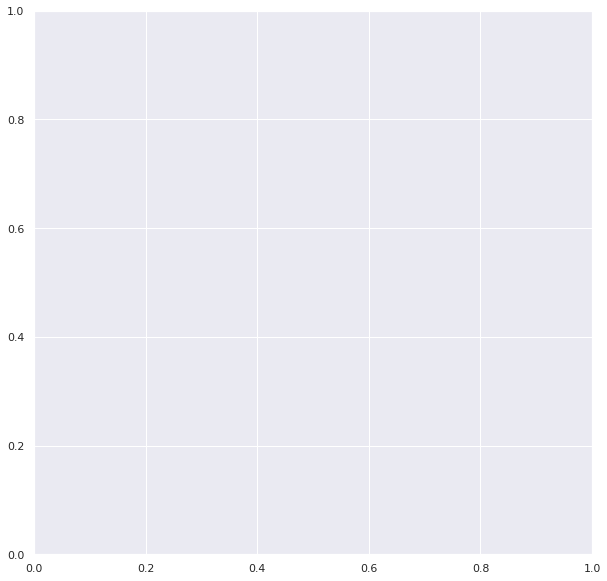

In [79]:
# initialise data of lists.
data = {'Stage':ls_stage,
        'Topic':ls_topic,
        'Keyword': ls_kword,
        'Value': ls_weight}
 
# Create DataFrame
df = pd.DataFrame(data)
 
df['Stage_topic'] = df['Stage'].astype(str).str[0] + df['Topic'].astype(str) 


ls_words = df['Keyword'].unique().tolist()
ls_stage_topic = df['Stage_topic'].unique().tolist()

# heatmap dataframe empty
df_heatmap = pd.DataFrame(np.array(np.zeros(len(df['Keyword'].unique()))),
                     columns=['col1'],
                     index=ls_words)


# populate heatmap
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
df_heatmap = df_heatmap.drop(['col1'], axis=1)    
    
# output heatmap 

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap="Blues", cbar=False)

In [ ]:
for stage_topic in ls_stage_topic:
    
    ls_iweight = []
    for ikey in ls_words:

        ivalue = df['Value'][(df['Stage_topic']==stage_topic) & (df['Keyword'] == ikey)].values
        if len(ivalue) == 1:
            iweight = ivalue[0]
        else:
            iweight = 0 
#         print(ikey, iweight)
        ls_iweight.append(iweight)

    df_heatmap[stage_topic] = ls_iweight
    df_heatmap
    
# my_list = ['training', 'technology', 'forum', 'management', 'online', 'sharing', 'topic']    
    
# df_heatmap  = df_heatmap[df_heatmap.index.isin(my_list)]    

In [ ]:
# df_heatmap = df_heatmap.drop(['col1'], axis=1)

In [ ]:


fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.color_palette("Blues", as_cmap=True)
sns.heatmap(df_heatmap, linewidths=.5, ax=ax, cmap="Blues", cbar=False)


# ax = sns.heatmap(df_heatmap)

In [ ]:
filter_col = [col for col in df_heatmap if col.startswith('k')]
filter_col



In [ ]:

df_knowlede = df_heatmap[filter_col]

df_knowlede = df_knowlede[df_knowlede[filter_col] > 0]


In [ ]:


df_transposed = df_heatmap[filter_col].T

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))         # Sample figsize in inches
sns.heatmap(df_transposed,  cmap="Blues")